In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch import nn
from torch.functional import F
from torchvision.transforms import v2
import os
from PIL import Image

In [2]:
train_dir = "data/train"
test_dir = "data/test"

to_tensor = v2.ToTensor()

mean = torch.zeros(3)
std = torch.zeros(3)
num_images = 0


for root in [train_dir,test_dir]:
    for subdir, _, files in os.walk(root):
        for file_name in files:
            if file_name.lower().endswith('.jpg'):
                img_path = os.path.join(subdir, file_name)
                try:
                    img = Image.open(img_path).convert('RGB')
                    tensor = to_tensor(img)  # [C, H, W]
                    mean+= torch.mean(tensor,dim=[1,2])
                    std +=torch.std(tensor,dim=[1,2])
                    num_images += 1
                except Exception as e:
                    print(f"Error reading {img_path}: {e}")

if num_images == 0:
    raise ValueError("No image found")

mean /= num_images
std /= num_images

print(f"Mean: {mean}")
print(f"Std:  {std}")
print(f"Images number: {num_images}")

/home/vadimpp/.local/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Mean: tensor([0.5074, 0.5074, 0.5074])
Std:  tensor([0.2121, 0.2121, 0.2121])
Images number: 35887


=> initial dataset was normalized

#### Dataset creation:
Schema of initial data (also mentioned in format.json file):
- data:
    - train:
        - angry
        - disgust
        - ...etc
    - test:
        - angry
        - disgust
        - ...etc

Let's initialize a appropriated Dataset class.

In [3]:
from torch.utils.data import DataLoader, Dataset
import json

class FER_dataset(Dataset):
    def __init__(self, img_dir, train = True, transforms = None, aug_rate = 0.0, aug_transforms = None):
        self.img_dir = os.path.join(img_dir, "train" if train else "test")
        self.transforms = transforms

        with open(os.path.join(img_dir,"format.json"),"r") as fm:
            self.format = json.load(fm)

        self.length = 0
        self.files = []
        
        # Using one-hot encoding to encode image class
        self.targets = torch.eye(len(self.format.keys())) 

        for _dir, _target in self.format.items():
            path = os.path.join(self.img_dir,_dir)
            list_files = os.listdir(path)
            self.length += len(list_files)
            # Extending files array by filepath <-> target_value pairs
            self.files.extend(map(lambda _x: (os.path.join(path,_x),_target), list_files))
        
        # Creating an array of random indexes of augmentation dataset desired rate  
        self.aug_files = np.random.randint(0,self.length,size=round(self.length*aug_rate))
        self.aug_transforms = aug_transforms

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # Opening an image and associating a target one-hot vector
        path_file, target = self.files[idx]
        t = self.targets[target]
        img = Image.open(path_file)

        # Application of transformations if any
        if self.transforms:
            img = self.transforms(img)
        if idx in self.aug_files:
            img = self.aug_transforms(img)
        
        return img, t

In [4]:

tfr = v2.Compose([
    v2.ToTensor(),
    v2.Normalize(mean = mean, std = std),
    v2.Grayscale()
])
id_to_cl = {}
with open(os.path.join("./data","format.json"),"r") as fm:
    id_to_cl = {idx:cl for cl,idx in json.load(fm).items()}

train_ds = FER_dataset(img_dir = "./data", train=True, transforms=tfr)
train_loader = DataLoader(train_ds,shuffle=True,batch_size=32)
test_ds = FER_dataset(img_dir = "./data", train=False, transforms=tfr)
test_loader = DataLoader(test_ds,shuffle=True,batch_size=32)

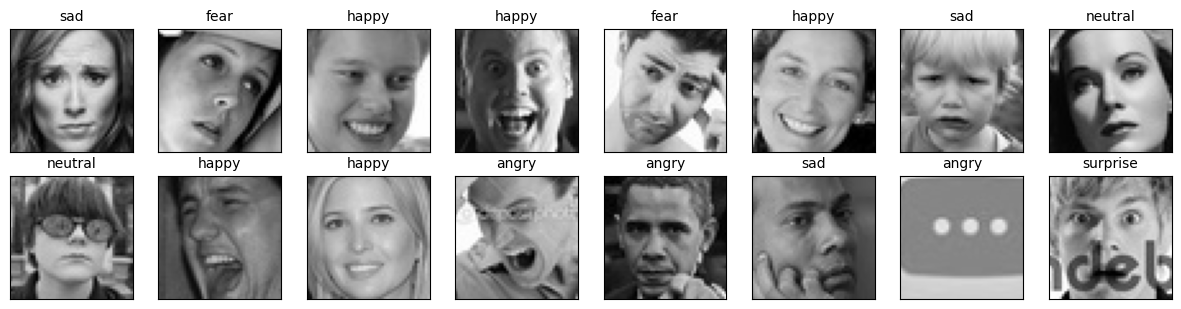

In [5]:
from random import randint

plt.figure(figsize = (15,15))

to_img = v2.ToPILImage()

for i in range(16):
    img, label = train_ds[randint(0,len(train_ds))]
    img = img.permute(1, 2, 0).numpy()
    img = img * std.numpy() + mean.numpy()              
    img = img.clip(0, 1)                
    plt.subplot(8, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(id_to_cl[torch.argmax(label).item()],fontsize = 10)

    plt.imshow(img)
plt.show()

#

Let's try direct multilayer CNN network with reducing

In [13]:


class direct_cnn_model(torch.nn.Module):
    def __init__(self, num_classes=7):
        super(direct_cnn_model, self).__init__()
        
        # Block 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # channels_in=1 (Grayscale normalized)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)
        self.drop1 = nn.Dropout(0.2)
        
        # Block 2
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)
        self.drop2 = nn.Dropout(0.3)
        
        # Block 3
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2)
        self.drop3 = nn.Dropout(0.4)
        
        # Block 4
        self.conv7 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2)
        self.drop4 = nn.Dropout(0.5)
        
        # full connected
        self.fc = nn.Linear(256 * 3 * 3, num_classes)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.drop1(x)
        # Block 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.drop2(x)
        
        # Block 3
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.drop3(x)
        
        # Block 4
        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = self.pool4(x)
        x = self.drop4(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # FC
        x = self.fc(x)    
        return x

In [14]:
direct_cnn_model = direct_cnn_model()
criterion = nn.CrossEntropyLoss()
direct_cnn_model_optim = torch.optim.Adam(params=direct_cnn_model.parameters(), lr=1e-3)

In [15]:
dc_loss_ep, dc_acc_ep = train_and_validate(direct_cnn_model,direct_cnn_model_optim,criterion,train_loader,test_loader,epochs=5)

Epoch [1/5], loss_mean=1.858 => P[good class] = 0.16: 100%|██████████| 898/898 [02:45<00:00,  5.42it/s]
Epoch [1/5] eval: Accuracy=0.339: 100%|██████████| 225/225 [00:17<00:00, 13.08it/s]
Epoch [2/5], loss_mean=1.449 => P[good class] = 0.23: 100%|██████████| 898/898 [02:51<00:00,  5.25it/s]
Epoch [2/5] eval: Accuracy=0.501: 100%|██████████| 225/225 [00:17<00:00, 13.09it/s]
Epoch [3/5], loss_mean=1.281 => P[good class] = 0.28: 100%|██████████| 898/898 [02:40<00:00,  5.59it/s]
Epoch [3/5] eval: Accuracy=0.547: 100%|██████████| 225/225 [00:15<00:00, 14.25it/s]
Epoch [4/5], loss_mean=1.197 => P[good class] = 0.30: 100%|██████████| 898/898 [02:21<00:00,  6.34it/s]
Epoch [4/5] eval: Accuracy=0.560: 100%|██████████| 225/225 [00:14<00:00, 15.01it/s]
Epoch [5/5], loss_mean=1.144 => P[good class] = 0.32: 100%|██████████| 898/898 [02:35<00:00,  5.78it/s]
Epoch [5/5] eval: Accuracy=0.579: 100%|██████████| 225/225 [00:16<00:00, 13.66it/s]


In [16]:
score_accuracy(direct_cnn_model,test_loader)

Accuracy=0.579: 100%|██████████| 225/225 [00:16<00:00, 13.36it/s]

0.5789913624965172


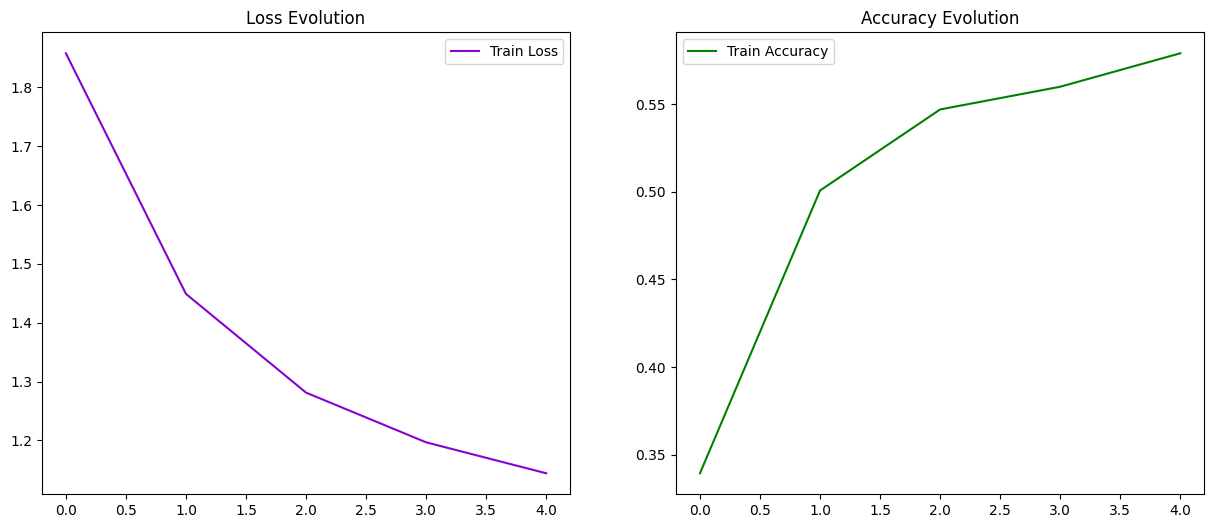

In [17]:
trace_loss_acc_evolution(dc_loss_ep, dc_acc_ep)

In [18]:
save_model(direct_cnn_model,"direct_conv_model.pt")

```
Epoch [1/5], loss_mean=1.850 => P[good class] = 0.16
Epoch [1/5] eval: Accuracy=0.289
Epoch [2/5], loss_mean=1.507 => P[good class] = 0.22
Epoch [2/5] eval: Accuracy=0.416
Epoch [3/5], loss_mean=1.391 => P[good class] = 0.25
Epoch [3/5] eval: Accuracy=0.456
Epoch [4/5], loss_mean=1.331 => P[good class] = 0.26
Epoch [4/5] eval: Accuracy=0.512
Epoch [5/5], loss_mean=1.298 => P[good class] = 0.27
Epoch [5/5] eval: Accuracy=0.516
```

After 5 epoch of training with direct CNN-based architecture mean CrossEntropy loss stuck on 1.3 value.
This result means in our case with one-hot encoding targets 

L(y_pred,y_true) = -log2(P(true_prediction))*1

=> P(true_predicted_class) = 1/exp(L(y_p,y_t)) =(after 5 epoch)= 0.273 
However, Accuracy on test subset is more than 50%, what may be linked with class disbalance 


---

In [ ]:
class HRNet(nn.Module):
    def __init__(self,nb_layers,):
        super(HRNet,self).__init__()


In [8]:
def train_and_validate(model:nn.Module, optim:torch.optim, criterion:nn, train_loader, test_loader,epochs=10):
    loss_epoch = []
    acc_epoch = []
    for ep in range(epochs):
        model.train()
        lm_count = 0
        loss_mean = 0.0 
        tqdm_loader = tqdm(train_loader, leave=True)
        for (x,y) in tqdm_loader:
            pred = model(x)
            loss = criterion(pred,y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            lm_count += 1
            loss_mean = 1/lm_count * loss.item() + (1 - 1/lm_count) * loss_mean
            tqdm_loader.set_description(f"Epoch [{ep+1}/{epochs}], loss_mean={loss_mean:.3f} => P[good class] = {np.exp(-loss_mean):.2f}")
        loss_epoch.append(loss_mean)
        Q = 0
        model.eval()
        tqdm_test_loader = tqdm(test_loader, leave=True)
        for x_test, y_test in tqdm_test_loader:
            with torch.no_grad():
                p = model(x_test)
                y_test = torch.argmax(y_test, dim=1)
                p = torch.argmax(p, dim=1)
                #print(p[0],y_test[0])
                Q += torch.sum(p == y_test).item()
            tqdm_test_loader.set_description(f"Epoch [{ep+1}/{epochs}] eval: Accuracy={Q/len(test_ds):.3f}")
        acc_epoch.append(Q/len(test_ds))
    return (loss_epoch,acc_epoch)


def trace_loss_acc_evolution(loss_epoch,acc_epoch):
    plt.figure(figsize=(15,6))

    # Plotting the training and validation loss
    plt.subplot(1,2,1)
    plt.plot(loss_epoch, label='Train Loss', color='#8502d1')
    plt.legend()
    plt.title('Loss Evolution')

    plt.subplot(1,2,2)
    plt.plot(acc_epoch, label='Train Accuracy', color='green')
    plt.legend()
    plt.title('Accuracy Evolution')

def score_accuracy(model:nn.Module,test_loader):
    Q = 0

    pred = []
    tqdm_test_loader = tqdm(test_loader, leave=True)
    for x_test, y_test in tqdm_test_loader:
        with torch.no_grad():
            p = model(x_test)
            y_test = torch.argmax(y_test, dim=1)
            p = torch.argmax(p, dim=1)
            #print(p[0],y_test[0])
            Q += torch.sum(p == y_test).item()
        tqdm_test_loader.set_description(f"Accuracy={Q/len(test_ds):.3f}")
    Q = Q/len(test_ds)
    print(Q)

def save_model(model:nn.Module, filename):
    torch.save(model.state_dict(), os.path.join("./",filename))

